# Prepare

In [6]:
from pathlib import Path

from data import generate_grid_graph

PRECINCT_FN = "data/graph/grid_graph_5_by_5.json"
_ = generate_grid_graph(N=5, filename=PRECINCT_FN, num_districts=3)

# Sampling
Run Julia code to sample partitions, e.g.
```
./sampling/run.sh --map-file data/graph/grid_graph_5_by_5.json --output-file local/output/grid5x5/atlas.jsonl.gz --cycle-walk-steps 1e5 --pop-dev 0.1
```

# Analysis

In [7]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from data import generate_grid_shape
from hierachical import HClusters
from sample import SampleProcessor
from utils import (
    plot_district,
    plot_plan,
    plot_words_centroids,
    plot_words_list,
)
from word import PlanWordBuilder, WordStat

PRECINCT_FN = "data/graph/grid_graph_5_by_5.json"
SAMPLE_FN = "local/output/grid5x5/atlas.jsonl.gz"
OUT_DIR = "local/output/grid5x5/processed"
gdf = generate_grid_shape(5)

In [10]:
sp = SampleProcessor(PRECINCT_FN, OUT_DIR)
# run this once to process samples and dump artifacts for future use
sp.clean()
sp.process_samples([SAMPLE_FN], max_length=1000, min_step=100)
sp.load_processed()

Reading local/output/grid5x5/atlas.jsonl.gz


atlas:   0%|          | 0/1000 [00:00<?, ?samples/s]

plans:   0%|          | 0/1000 [00:00<?, ?it/s]

We give each district a unique `district_uid'. Districts are stored via the precincts that they contain (i.e. as an array of ints).

In [12]:
sp.df_districts.head()

,district_str,district_uid
0,1.2.3.6.7.8.12.13,0
1,0.5.10.11.15.16.20.21,1
2,4.9.14.17.18.19.22.23.24,2
3,15.16.17.18.20.21.22.23,3
4,3.4.7.8.9.13.14.19.24,4


Each plan is stored using `district_uid's and is given a 'plan_id'

In [14]:
sp.df_plans.head()

,step,plan_id,sample_tag,plan,plan_str
0,1000,0,atlas,"[0, 1, 2]",0.1.2
1,2000,1,atlas,"[3, 4, 5]",3.4.5
2,3000,2,atlas,"[6, 7, 8]",6.7.8
3,4000,3,atlas,"[3, 9, 10]",3.9.10
4,5000,4,atlas,"[11, 12, 10]",10.11.12


We visualize the first sampled plan and its first district

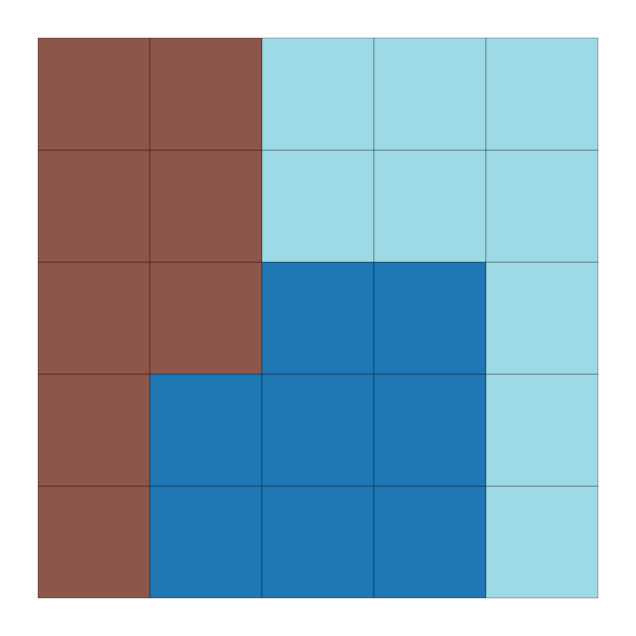

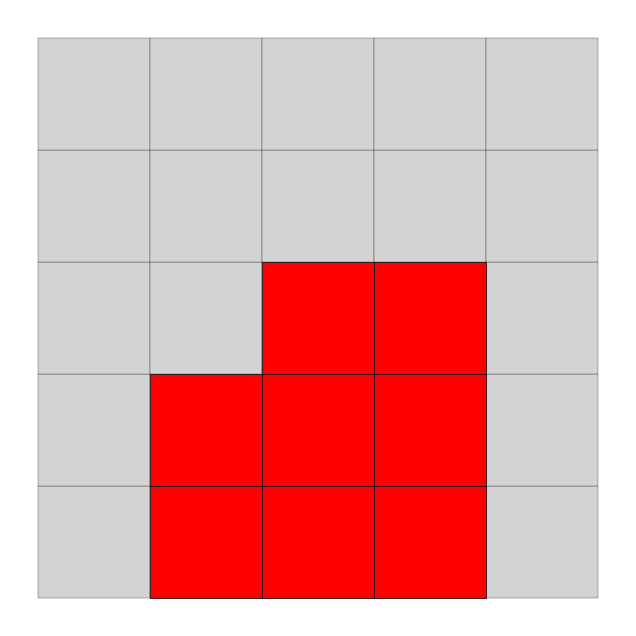

In [38]:
plan = sp.df_plans.iloc[0].plan
labels = sp.decode_plan_vector(plan)
plot_plan(gdf, labels)
plt.show()

district = sp.decode_district(plan[0])
plot_district(gdf, district)
plt.show()

Next, we run hcc and infer clusters at a given number of letters.

In [15]:
sp.load_distance_matrix()
sp.ensure_linkage()

num_letters = 20
hc = HClusters(sp)
hc.update_clusters(num_letters)
hc.kcentroids()

  0%|          | 0/277140 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 0: rel_improvement = 0.10887428101889893
epoch 1: rel_improvement = 0.011065006915629323


We visualize some letters 

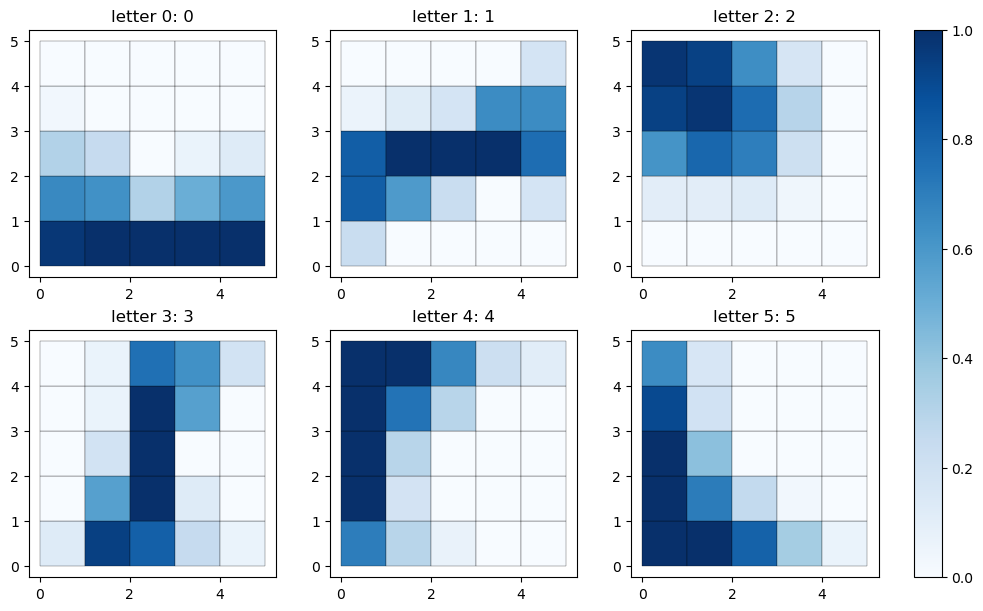

In [17]:
letters = list(range(min(6, num_letters)))
plot_words_list(gdf, hc.cluster_densities, letters, cols=3, figsize=(10, 6))
plt.show()

We then use the letters to construct words via beam search with a prescribed `word_degree'

In [16]:
pw = PlanWordBuilder(sp, hc, word_degree=10, verbose=True, centroid_norm="l1").build()
pw.df_words.head()

Computing letter distances:   0%|          | 0/745 [00:00<?, ?it/s]

Enumerating words:   0%|          | 0/548 [00:00<?, ?it/s]

,plan_uid,plan,word,distance,min_distance,plan_str,word_str,word_uid
0,0,"[0, 1, 2]","[4, 7, 16]",8.0,8.0,0.1.2,4.7.16,156
1,0,"[0, 1, 2]","[7, 16, 17]",9.0,8.0,0.1.2,7.16.17,244
2,0,"[0, 1, 2]","[4, 10, 16]",10.0,8.0,0.1.2,4.10.16,135
3,0,"[0, 1, 2]","[4, 7, 13]",11.0,8.0,0.1.2,4.7.13,154
4,0,"[0, 1, 2]","[4, 14, 16]",11.0,8.0,0.1.2,4.14.16,145


We compute stationary distribution under some POU (controlled by temperature).

In [18]:
ws = WordStat(pw, temp=0.0, verbose=False)
df_top = ws.stationary_table().head(3).reset_index(drop=True)
df_top

/home/zijianw/gmstrat/word.py:315: RuntimeWarning: invalid value encountered in multiply
  df_words["phi"] = np.exp(-self.temp * (ratio - 1.0))


,word_uid,word_str,word,stationary
0,221,6.7.16,"[6, 7, 16]",0.0270
1,110,2.7.16,"[2, 7, 16]",0.0252
2,74,13.14.17,"[13, 14, 17]",0.0235


This is the flux matrix

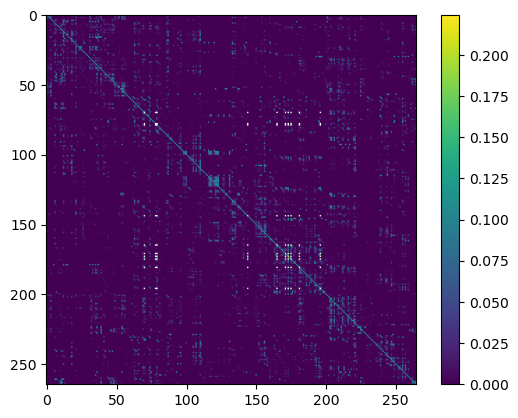

In [57]:
plt.imshow(ws.flux_matrix())
plt.colorbar()

These are some most frequent words under the stationary distribution

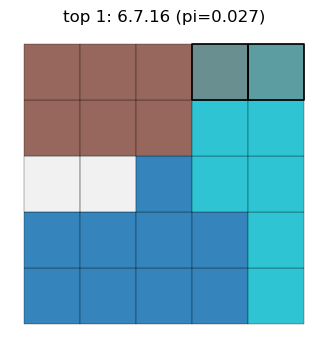

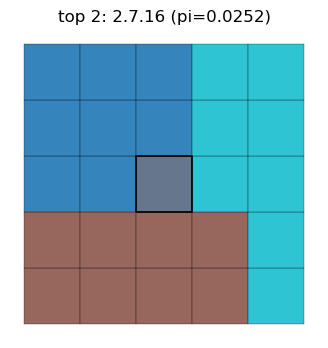

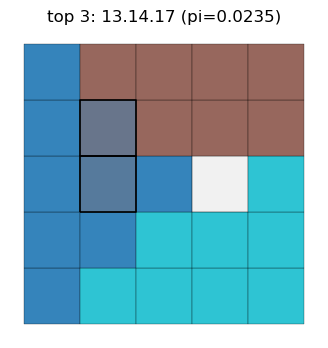

In [58]:
for i, row in df_top.iterrows():
    fig, ax = plot_words_centroids(
        gdf, hc.cluster_densities, row.word, ltr=True, figsize=(4, 4)
    )
    ax.set_title(f"top {i + 1}: {row.word_str} (pi={row.stationary:.3g})")
    plt.show()